# Estruturas Criptográficas - Criptografia e Segurança da Informação

[Grupo 03](https://paper.dropbox.com/doc/Estruturas-Criptograficas-2023-2024-Trabalhos-Praticos-8WcsdZARGLv0nXS9KasmK)

(PG54177) Ricardo Alves Oliveira 

(PG54236) Simão Oliveira Alvim Barroso

## TP3 - Exercício 1

1. No capítulo 5 dos apontamentos é descrito o chamado Hidden Number Problem. No capítulo 8 dos apontamentos é discutida um artigo de  Nguyen & Shparlinsk , onde se propõem reduções do HNP a problemas difíceis em reticulados. Neste trabalho pretende-se construir, com a ajuda do Sagemath, uma implementação da solução discutida nos apontamentos para resolver o HNP com soluções aproximadas dos problemas em reticulados.


## Resolução

Ao longo deste playbook iremos apresentar os passos tomados para resolver o exercício proposto juntamente com as respetivas funções implementadas. 

Para tal, começamos por importar a biblioteca `sagemath` e definir as variáveis necessárias seguindo o defenido por [Nguyen & Shparlinsk](https://www.dropbox.com/s/76k1zkz9wautty0/igor-slides.pdf?e=1&dl=0). Isto define que para um dado `d` temos as seguintes variáveis:

- `p≈2​d​​`
- `k>√​d​​​+log​2​​d`
- `n>2√​d​​​`

Tendo em conta estas definições, a implementação do HNP, que dita `p` como um número primo, e seja `s` um qualquer número inteiro tal que `1<s<p`, temos então:

In [29]:
from sage.all import *
from sage.matrix.matrix_rational_dense import *

d = 12
p = next_prime(2^d)
n = 4 * ceil(sqrt(d))
k = ceil(sqrt(d) + log(d, 2))
s = randint(1, p - 1)

print(f"d = {d}")
print(f"p = {p}")
print(f"n = {n}")
print(f"k = {k}")
print(f"s = {s}")

d = 12
p = 4099
n = 16
k = 8
s = 3036


De seguida, definimos a função auxiliar `represent_in_Zq` que, recebendo um número `x` e um módulo `q`, devolve a representação de `x` no intervalo `[0, q-1]`.

In [16]:
def represent_in_Zq(val, max):
    return val % max

A próxima função a ser implementada é fundamental para o cálculo do `HNP`, sendo esta a `msb_k`. Esta deve, para qualquer `y` pertencente a `ZZp`, devolver um `u E ZZp` tal que:

$$\,u = \text{msb}_k(y)\,\ \ se\ e\ só\ se\quad 0 \leq y - B\,u < B$$

Onde,
$$\quad B\equiv p/\lambda\,\ \ para\ \ \lambda \equiv 2^k\quad$$


In [17]:
def msb_k(y, k, p):
    B = p // (2 ** k)
    return y // B

Com esta função implementada, podemos agora criar os pares que serão utilizados para a resolução do `HNP`. Para tal, definimos a função `generate_pairs` que tem por objetivo gerar `n` pares `(x_i, u_i)` tal que, para um qualquer `x_i` pertencente a `ZZp`, `u` é o resultado da função `msb_k` aplicada a `s * x_i % q`. 

Esta regra pode ser representada pela seguinte fórmula, presente no [capítulo 5 dos apontamentos](https://paper.dropbox.com/doc/Capitulo-5-Grupos-Ciclicos-Formas-Bilineares.-Vin0kvNvqrnugLwI02UuH): 

$$\,u_i\;=\; \text{msb}_k(s\times x_i\bmod q)\,$$

Com base nisto podemos então gerar o oráculo que será utilizado para a resolução do `HNP`. 

In [18]:
def generate_pairs(N, q, k, s):
    pairs = []
    for i in range(N):
        x_i = randint(0, q - 1)
        u_i = msb_k((s * x_i) % q, k, q)
        pairs.append((x_i, u_i))
    return pairs

pairs = generate_pairs(n, p, k, s)
print(pairs)

[(2112, 140), (37, 73), (2441, 196), (2316, 170), (769, 74), (1838, 55), (54, 203), (507, 5), (1909, 134), (766, 5), (2540, 142), (2298, 17), (2418, 185), (3434, 242), (2231, 30), (3547, 251)]


Tendo agora os varios pares `(x_i, u_i)` gerados, podemos então começar a implementar a resolução do `HNP` conforme o [capítulo 8 dos apontamentos](https://paper.dropbox.com/doc/Capitulo-8-Reticulados.-HvE0pRYOYOcAO6HAuG4Lr).

Para isso devemos começar por construir a matriz geradora tal que:

$$\,G\in\mathbb{Q}^{m\times m}\,\ \ com\ \ m=n+2$$

$$G'\,\equiv\,\begin{bmatrix}  p & 0 & \cdots & 0 & 0 & 0\\ 0 & p & \cdots & 0 & 0 & 0 \\ \cdots & \cdots & \cdots & \cdots & \cdots &\cdots\\ 0 & 0 &\cdots& p & 0 & 0 \\x_1 & x_2 & \cdots&x_n & A & 0 \\ -B\,u_1 & -B\,u_2 &\cdots& -B\,u_n & 0 & M\end{bmatrix}$$

Onde `x1, x2, ..., xn` e `u1, u2, ..., un` são os valores `(x_i,u_i)` anteriormente gerados pela função `generate_pairs`. A variável `B` mantém-se igual à definição anterior. `A` deve ser definido como `1/lambda`, relembrando que `lambda=2^k`. Finalmente `M`, segundo o descrito nos apontamentos, deve ser "um qualquer grande inteiro `M>>lambda`". 

In [32]:
def builg_G(oracle_inputs, secon, p, k):
    l = len(oracle_inputs) + 2  # Dimension of the lattice
    basis_vectors = []

    # Add basis vectors for oracle inputs
    for i in range(l-2):
        p_vector = [0] * (l)
        p_vector[i] = p
        basis_vectors.append(p_vector)


    # Add the last basis vector with appropriate values
    A = 1 / (2 ** k)
    M = p * (2 ** k)
    last_basis_vector = oracle_inputs + [A,0]
    basis_vectors.append(last_basis_vector)
    last_last = secon + [0, M]
    basis_vectors.append(last_last)
    return Matrix(QQ, basis_vectors)

B = p / (2 ** k)
G = builg_G([x_i for x_i, _ in pairs], [-B * u_i for _, u_i in pairs], p,k)
print(G)

[        4099            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0]
[           0         4099            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0]
[           0            0         4099            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0]
[           0            0            0         4099            0            0            0            0            0            0            0            0            0            0            0            0            0            0]
[           0            0            0            0    


O próximo passo é aplicar a redução `BKZ` a `G` para a sua forma reduzida, ou aproximada. Para tal, definimos a função `reduced_matrix` que recebe a matriz `G` e devolve a sua forma reduzida, com base no algoritmo em uso.

No entantom, apesar de a redução `BKZ` estar disponivel na documentação do [SageMath] (https://doc.sagemath.org/html/en/reference/matrices/sage/matrix/matrix_rational_dense.html#sage.matrix.matrix_rational_dense.Matrix_rational_dense.BKZ), esta apresentou problemas na sua execução dependendo da versão do SageMath utilizada. Assim, optamos por implementar utilizar a função `LLL` para obter a lattice reduzida, ou a sua aproximação.

In [35]:
def reduce_lattice(lattice):
    return lattice.LLL()

print(type(G))

reduced_lattice = reduce_lattice(G)
print(reduced_lattice)

<class 'sage.matrix.matrix_rational_dense.Matrix_rational_dense'>
[        0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0 -4099/256         0]
[      269       356       111      -427       752      -484       298      1887      -244       280      -709       840      -775       581      -137      -769 -1209/256         0]
[      140      -409       713       433       -81       510       -43      -176       833      1060       -49      -919     -1470       150     -1397       895   493/128         0]
[    -1385      -492       998      -331      -809       -68       279       570       982      1225      -540      -424       196       -20       -87      1247  -339/128         0]
[     1468      -541       -19      1144      -498      -508      -568      -323     -1103       -11       306       -33       982     -1355      1279      -570    301/64         0]
[      529       182    

O passo final trata-se de obter o vetor `v` que, segundo a resolução do `HNP`, deve ser:

$$\begin{bmatrix} e_1 & e_2 & \cdots & e_{n+1} & M\end{bmatrix}$$

Onde `e1, e2, ..., en+1` são os primeiros `n+1` elementos da última linha da matriz reduzida `G`.

Com isto, conseguimos então obter o valor de `s` que resolve o `HNP` com soluções aproximadas dos problemas em reticulados. Basta para isso obter o valor de `en+1` que, pelo definido nos apontamentos é `s*A`. Uma vez que `A` é `1/lambda`, basta multiplicar `en+1` por `lambda` para obter o valor de `s`, garantindo que `s E ZZp`.

In [36]:
def get_secret_from_reduced_lattice(reduced_lattice, q, k):
    shortest_vector = reduced_lattice.row(-1)
    s = (shortest_vector[-2] * (2 ** k)).ceil()
    return represent_in_Zq(s, q)

found_secret = get_secret_from_reduced_lattice(reduced_lattice, p, k)
print("found_s:",found_secret)

found_s: 364


### Testes

Adicionalmente, podemos realizar testes para verificar este processo e a sua correta implementação. 

Apesar do valor poder ser observado como igual ao inicialmente definido, foi implementada uma função `verify_secret` que verifica se o valor de `s` obtido é igual ao valor inicialmente definido. Esta função deve receber os valores do oráculo e o novo segredo, devolvendo `True` caso, para todos os `x_i`, os valores resultantes da aplicação da função `msb_k` sejam iguais aos valores `u_i` do oráculo. Caso contrário, devolve `False`.

In [7]:
def verify_secret(ss, x_values, u_values, q, k):
    for x, u in zip(x_values, u_values):
        if msb_k((ss * x) % q, k, q) != u:
            return False
    return True

# Verificar o segredo extraído
t = [x for x, _ in pairs]
u = [u for _, u in pairs] 
is_correct = verify_secret(found_secret, t, u, p, k)

if is_correct:
    print("O segredo extraído está correto.")
else:
    print("O segredo extraído está incorreto.")

O segredo extraído está correto.


In [43]:
def test_for_d(dd):
    pp = next_prime(2**dd)
    nn = 4 * ceil(sqrt(dd))
    kk = ceil(sqrt(dd) + log(dd, 2))
    ss = randint(1, pp - 1)

    
    ppairs = generate_pairs(nn, pp, kk, ss)

    BB = pp / (2 ** kk)
    GG = builg_G([xx for xx, _ in ppairs], [-BB * uu for _, uu in ppairs], pp, kk)
    
    rreduced_lattice = reduce_lattice(GG)
    
    ffound_secret = get_secret_from_reduced_lattice(rreduced_lattice, pp, kk)

    
    tt = [x for x, _ in ppairs]
    uu = [u for _, u in ppairs] 
    iis_correct = verify_secret(ffound_secret, tt, uu, pp, kk)
    
    return iis_correct


In [45]:
import time

times=[]

for i in range(5, 126):
    print(f"Testando para d = {i}\t| ", end='')
    #time start
    start = time.time()
    for _ in range(100):
        result=test_for_d(i)
    #time end
    end = time.time()
    times.append((i,(end-start)/100))
    print(f"Resultado: {result}\t| Tempo: {(end-start)/100}")

Testando para d = 5	| Resultado: True	| Tempo: 0.0042603397369384765
Testando para d = 6	| Resultado: True	| Tempo: 0.003992326259613037
Testando para d = 7	| Resultado: True	| Tempo: 0.003999013900756836
Testando para d = 8	| Resultado: True	| Tempo: 0.003881392478942871
Testando para d = 9	| Resultado: True	| Tempo: 0.003675692081451416
Testando para d = 10	| Resultado: True	| Tempo: 0.005639822483062744
Testando para d = 11	| Resultado: True	| Tempo: 0.005959815979003906
Testando para d = 12	| Resultado: True	| Tempo: 0.006222991943359375
Testando para d = 13	| Resultado: True	| Tempo: 0.006057145595550537
Testando para d = 14	| Resultado: True	| Tempo: 0.006171495914459229
Testando para d = 15	| Resultado: True	| Tempo: 0.006137731075286865
Testando para d = 16	| Resultado: True	| Tempo: 0.005276095867156982
Testando para d = 17	| Resultado: True	| Tempo: 0.008319664001464843
Testando para d = 18	| Resultado: True	| Tempo: 0.008511765003204346
Testando para d = 19	| Resultado: True

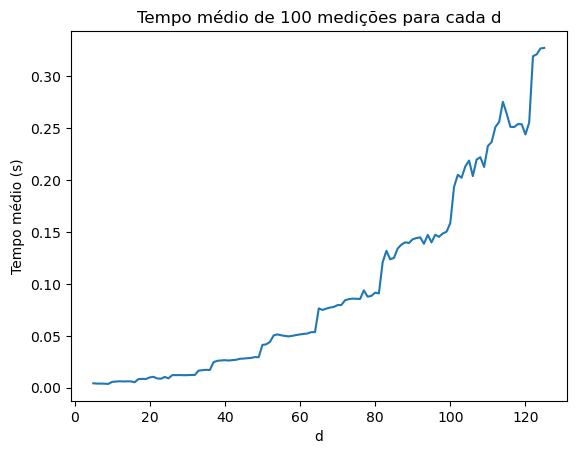

In [46]:
# make a graph of the results
import matplotlib.pyplot as plt

x = [i for i, _ in times]
y = [t for _, t in times]

plt.plot(x, y)
plt.xlabel("d")
plt.ylabel("Tempo médio (s)")
plt.title("Tempo médio de 100 medições para cada d")
plt.show()
